# Jena Climate Time Series - Weather

---

[dataset](https://www.kaggle.com/mnassrib/jena-climate)

<small> *note: the output was run on GPU mode*

In [2]:
import numpy as np
import pandas as pd
np.random.seed(233)

# only use the last three years (2013-2016)
train = pd.read_csv('jena_climate_2009_2016.csv', parse_dates=['Date Time'])
train[train['Date Time'] == '2013-01-01 00:00:00']

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
210525,2013-01-01,983.57,5.69,280.18,1.36,73.6,9.16,6.74,2.42,4.28,6.86,1225.55,1.75,3.04,173.9


In [3]:
train_copy = train.copy()
train = train.iloc[210525:].reset_index(drop=True)
train.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2013-01-01 00:00:00,983.57,5.69,280.18,1.36,73.6,9.16,6.74,2.42,4.28,6.86,1225.55,1.75,3.04,173.9
1,2013-01-01 00:10:00,983.44,5.67,280.16,1.34,73.6,9.15,6.73,2.41,4.27,6.85,1225.50,2.23,3.08,179.1
2,2013-01-01 00:20:00,983.32,5.70,280.20,1.39,73.7,9.16,6.75,2.41,4.28,6.87,1225.22,2.19,3.40,176.3
3,2013-01-01 00:30:00,983.16,5.61,280.13,1.38,74.1,9.11,6.75,2.36,4.28,6.86,1225.40,1.73,2.36,177.4
4,2013-01-01 00:40:00,983.04,5.54,280.07,1.35,74.3,9.07,6.74,2.33,4.27,6.85,1225.55,2.46,3.84,184.8


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210026 entries, 0 to 210025
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Date Time        210026 non-null  datetime64[ns]
 1   p (mbar)         210026 non-null  float64       
 2   T (degC)         210026 non-null  float64       
 3   Tpot (K)         210026 non-null  float64       
 4   Tdew (degC)      210026 non-null  float64       
 5   rh (%)           210026 non-null  float64       
 6   VPmax (mbar)     210026 non-null  float64       
 7   VPact (mbar)     210026 non-null  float64       
 8   VPdef (mbar)     210026 non-null  float64       
 9   sh (g/kg)        210026 non-null  float64       
 10  H2OC (mmol/mol)  210026 non-null  float64       
 11  rho (g/m**3)     210026 non-null  float64       
 12  wv (m/s)         210026 non-null  float64       
 13  max. wv (m/s)    210026 non-null  float64       
 14  wd (deg)         210

In [74]:
train.shape, train['Date Time'].iloc[-1]

((210026, 15), Timestamp('2017-01-01 00:00:00'))

In [75]:
train.isna().sum()

Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

# Exploratory Data Analysis

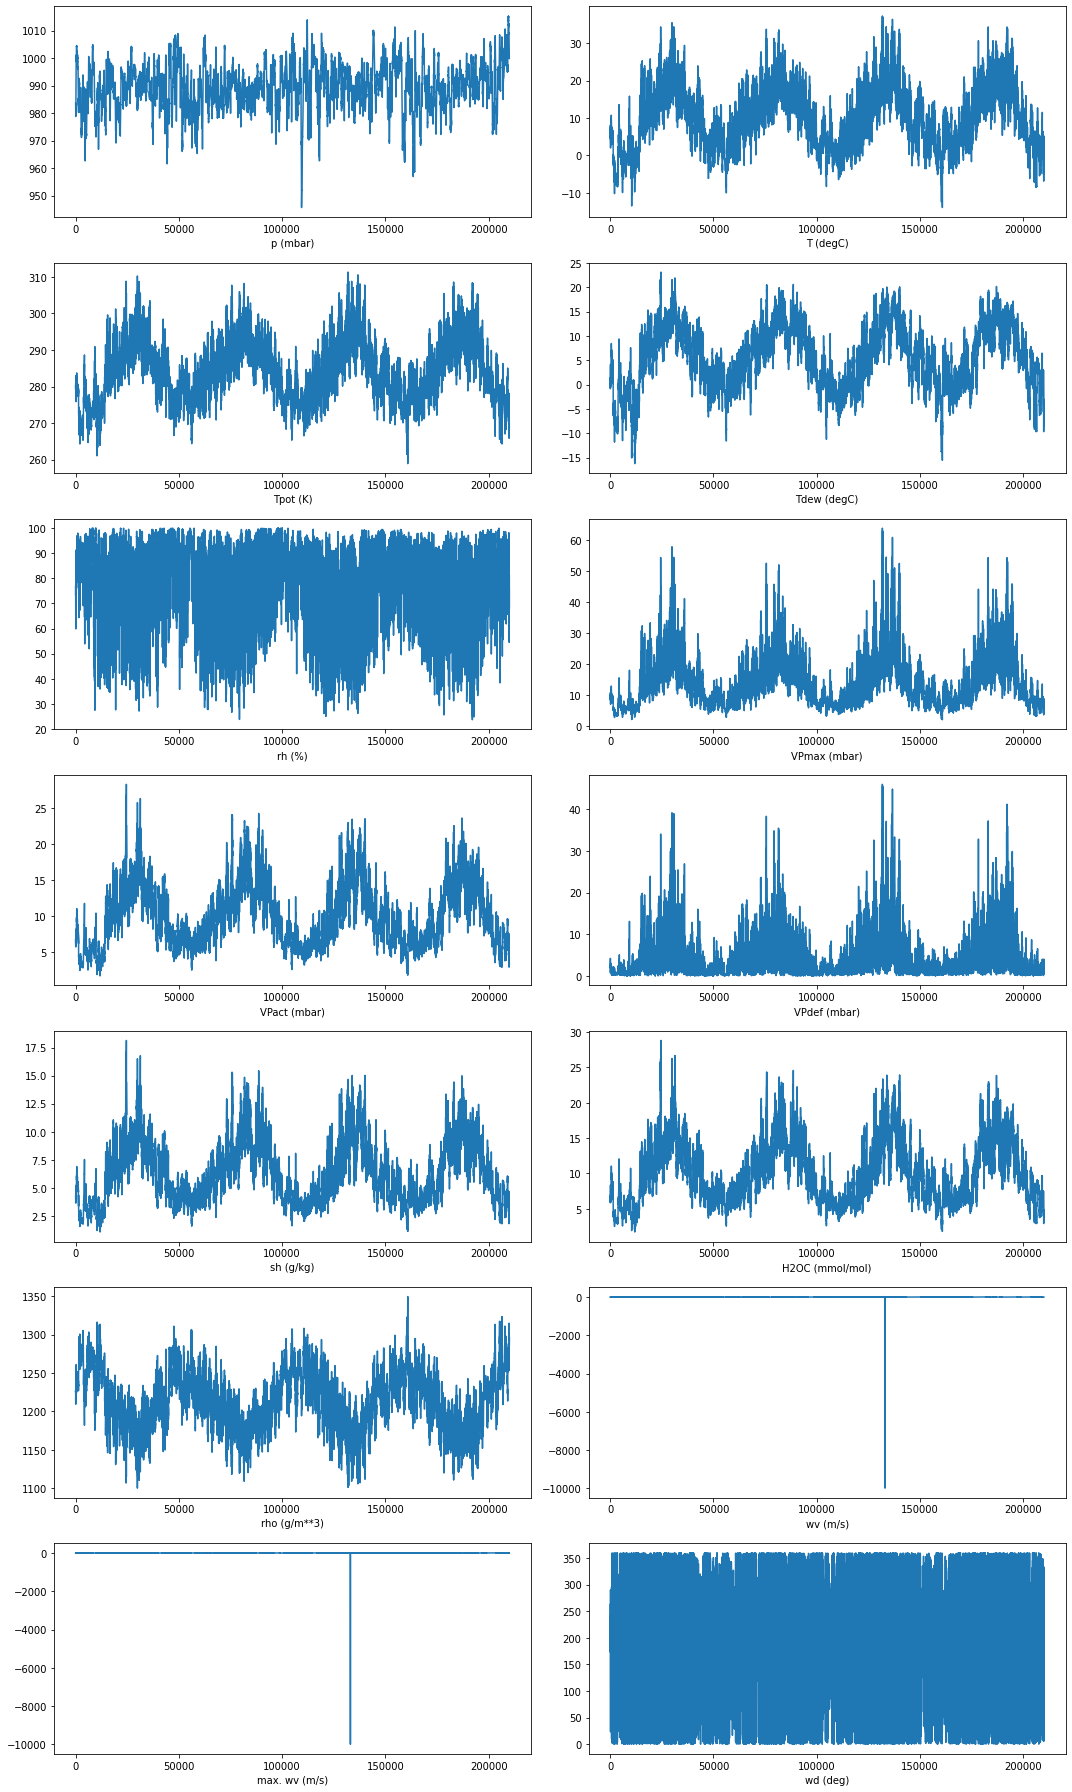

In [76]:
# only choose column 'T (degC)' because the pattern almost the same for all columns
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(7, 2, figsize=(15,25))
plt.tight_layout()
i = 1
for r in range(7):
  plt.tight_layout()
  for c in range(2):
    axs[r][c].plot(train[train.columns[i]])
    axs[r][c].set(xlabel=train.columns[i])
    plt.tight_layout()
    i += 1

# Data Preparation

In [4]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
tf.random.set_seed(233)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

# data_sample = windowed_dataset(train['T (degC)'], 60, 64, 100)

In [6]:
train.shape[0] * .8, train.shape[0] * .2 #42006

(168020.80000000002, 42005.200000000004)

In [7]:
# Validation (+-20%) - just take it like that because timestamp every 10 minutes thus skip the daily/monthly cut
### train_data, valid_data = train_test_split(train, stratify=train['T (degC)'], test_size=.2)
val_index = int(len(train) - 42006)

train_temp = train[['T (degC)']].iloc[:val_index]
valid_temp = train[['T (degC)']].iloc[val_index:]

scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train_temp[['T (degC)']])
scaled_valid = scaler.transform(valid_temp[['T (degC)']])

LNGTH, LEN2, BATCH = 168019, 42005, 32

train_gen = TimeseriesGenerator(scaled_train, scaled_train, length=LNGTH, batch_size=BATCH)
valid_gen = TimeseriesGenerator(scaled_valid, scaled_valid, length=LEN2, batch_size=BATCH)

# Test for three days in the future (334 datapoint)
future_dt = np.array([[i] for i in range(334)])     
future_gen = TimeseriesGenerator(future_dt, future_dt, length=333, batch_size=BATCH)

# Modelling

In [9]:
!pip install tensorflow-addons

     |████████████████████████████████| 686kB 12.5MB/s 


In [10]:
import time
import datetime
import tensorflow as tf
from tensorflow_addons.optimizers import AdamW
tf.random.set_seed(233)

SCHEDULE = tf.optimizers.schedules.PiecewiseConstantDecay([1407*20, 1407*30], [1e-3, 1e-4, 1e-5])
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay([10000, 15000], [1e-0, 1e-1, 1e-2])
LR = 1e-1 * schedule(step)
WD = lambda: 1e-4 * SCHEDULE(step)
OPTIMIZER = AdamW(learning_rate=SCHEDULE, weight_decay=WD)

def build_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True), input_shape=(168019,1)))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)))
  model.add(tf.keras.layers.Dense(128, activation='relu'))
  model.add(tf.keras.layers.Dropout(.3))
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dropout(.2))
  model.add(tf.keras.layers.Dense(32, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model.compile(loss=tf.losses.MeanSquaredError(), 
                optimizer=OPTIMIZER, 
                metrics=[tf.metrics.MeanAbsoluteError()])
  return model

def format_time(elapsed):
  '''
  Takes a time in seconds and returns a string hh:mm:ss
  '''
  # Round to the nearest second.
  elapsed_rounded = int(round((elapsed)))

  # Format as hh:mm:ss
  return str(datetime.timedelta(seconds=elapsed_rounded))

cb = tf.keras.callbacks

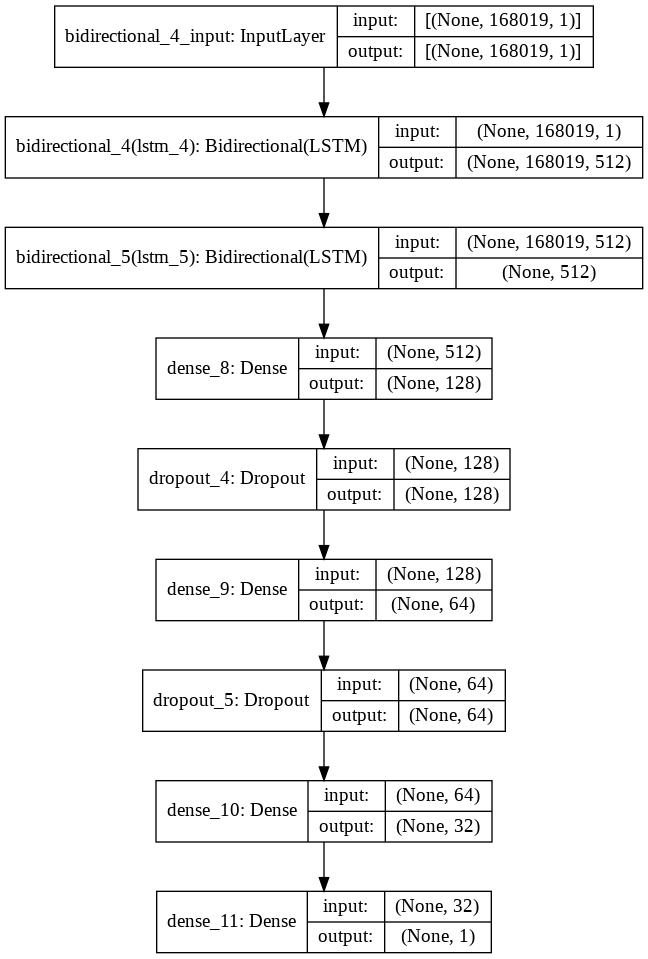

In [15]:
model = build_model()
stopper = cb.EarlyStopping(patience=3, min_delta=0.05, baseline=0.8,
              mode='min', monitor='val_mean_absolute_error', restore_best_weights=True,
              verbose=1)

tf.keras.utils.plot_model(model, show_shapes=True, rankdir='TP')

In [16]:
total_t0 = time.time()

hist = model.fit(train_gen, epochs=10, validation_data=valid_gen, callbacks=[stopper], verbose=2)

print('')
print('Training complete!')

print('Total training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))

Epoch 1/10
1/1 - 170s - loss: 0.0894 - mean_absolute_error: 0.2990 - val_loss: 0.0251 - val_mean_absolute_error: 0.1584
Epoch 2/10
1/1 - 90s - loss: 0.0891 - mean_absolute_error: 0.2985 - val_loss: 0.0133 - val_mean_absolute_error: 0.1151
Epoch 3/10
1/1 - 86s - loss: 0.0600 - mean_absolute_error: 0.2450 - val_loss: 0.0026 - val_mean_absolute_error: 0.0510
Epoch 4/10
1/1 - 97s - loss: 0.0405 - mean_absolute_error: 0.2013 - val_loss: 0.0053 - val_mean_absolute_error: 0.0730
Epoch 5/10
1/1 - 112s - loss: 0.0031 - mean_absolute_error: 0.0558 - val_loss: 0.0162 - val_mean_absolute_error: 0.1274
Epoch 6/10
1/1 - 103s - loss: 0.0036 - mean_absolute_error: 0.0600 - val_loss: 0.0086 - val_mean_absolute_error: 0.0925
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping

Training complete!
Total training took 0:10:57 (h:mm:ss)


# Evaluation

In [17]:
eval_df = pd.DataFrame(hist.history)
length = len(eval_df)

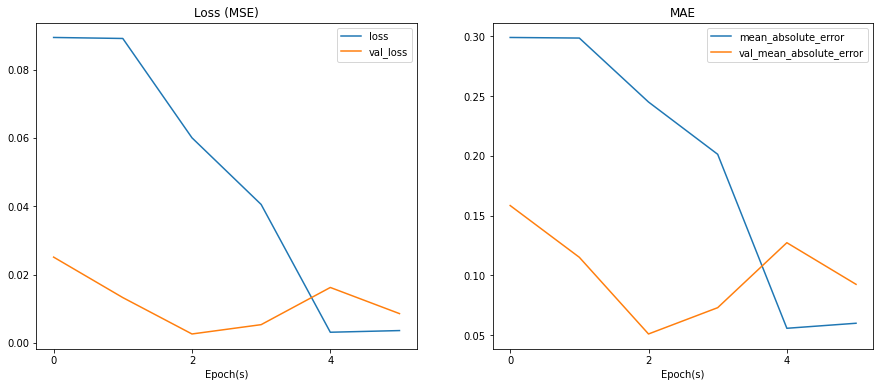

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))

eval_df[['loss','val_loss']].plot(ax=ax[0])
ax[0].set(title='Loss (MSE)', xlabel='Epoch(s)', xticks=range(0,length,2))

eval_df[['mean_absolute_error','val_mean_absolute_error']].plot(ax=ax[1])
ax[1].set(title='MAE', xlabel='Epoch(s)', xticks=range(0,length,2));

# Forecasting

In [45]:
# fit model & predict the future (only 3 days because this method will give a long time running)
def pred_future_deep(model):
    list_pred = []
    
    first_eval_batch = future_dt
    current_batch = first_eval_batch.reshape((1, 334, 1))
    
    for i in range(len(future_dt)):

        # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
        current_pred = [i for i in model.predict(current_batch)[0]]

        # store prediction
        list_pred.append(current_pred) 

#         if i == 0:
            # update batch to now include prediction and drop first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
            
#         current_batch = np.append(current_batch[:],[[current_pred]],axis=1)
        
    return list_pred

first_jan_2017 = pred_future_deep(model)
first_jan_2017 = scaler.inverse_transform(first_jan_2017)
first_jan_2017.shape

(334, 1)

In [62]:
res_sample = pd.DataFrame(first_jan_2017)
res_sample.columns = ['degC res']
res_sample['idx'] = [i for i in range(210026,210360)]
res_sample = res_sample.set_index(['idx'])

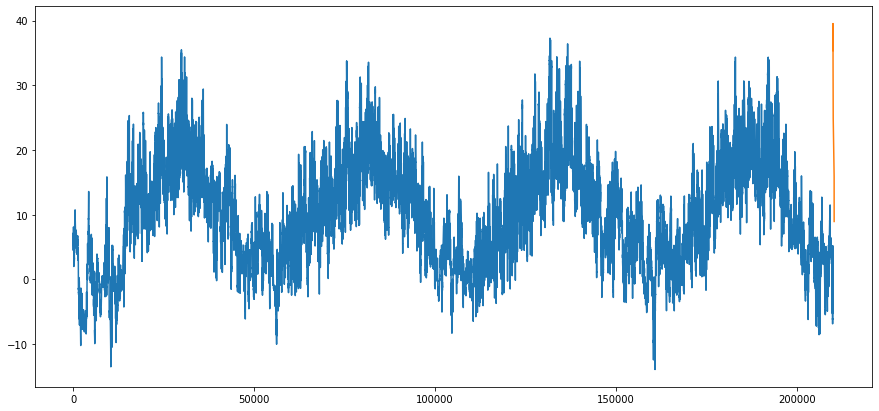

In [63]:
plt.figure(figsize=(15,7))
plt.plot(train['T (degC)'])
plt.plot(res_sample)
# plt.xticks(pd.date_range('2017-01-01 00:00:00', periods=334, freq='10min'))